# 은행 이탈 데이터 셋을 이용한 이진 분류
Binary Classification with a Bank Churn Dataset

# 참고사항:
- train 데이터셋에서 ['id' , 'surname'] drop 시킨 후 중복값 삭제
- 예측에 상관없는 ['customerid'] drop 후 모델링
- 이상치 제거하지 않고 진행

---

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
import time
from statsmodels.graphics.mosaicplot import mosaic

# 데이터 탐색 및 전처리
- train 데이터 컬럼
    - id: ID
    - CustomerId: 고객ID
    - Surname: 성(이름)
    - CreditScore: 신용점수
    - Geography: 지역(국가)
    - Gender: 성별
    - Age: 나이
    - Tenure: 가입기간
    - Balance: 잔액
    - NumOfProducts: 고객 보유 상품 수
    - HasCrCard: 신용카드 유무 (1: Yes, 0: No)
    - IsActiveMember: 활성 멤버쉽 (1: Yes, 0: No)
    - EstimatedSalary: 예상 급여
    - Exited: 이탈 유무(1: Yes, 0: No) => 타겟 컬럼

In [13]:
# 데이터 불러오기(train, test, submission)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')
original = pd.read_csv('./data/Churn_Modelling.csv')

In [14]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [15]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [16]:
# 불필요한 컬럼 삭제
train.drop(['id', 'Surname'], axis=1, inplace=True)

In [17]:
# train 데이터 null값 확인
train.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: >

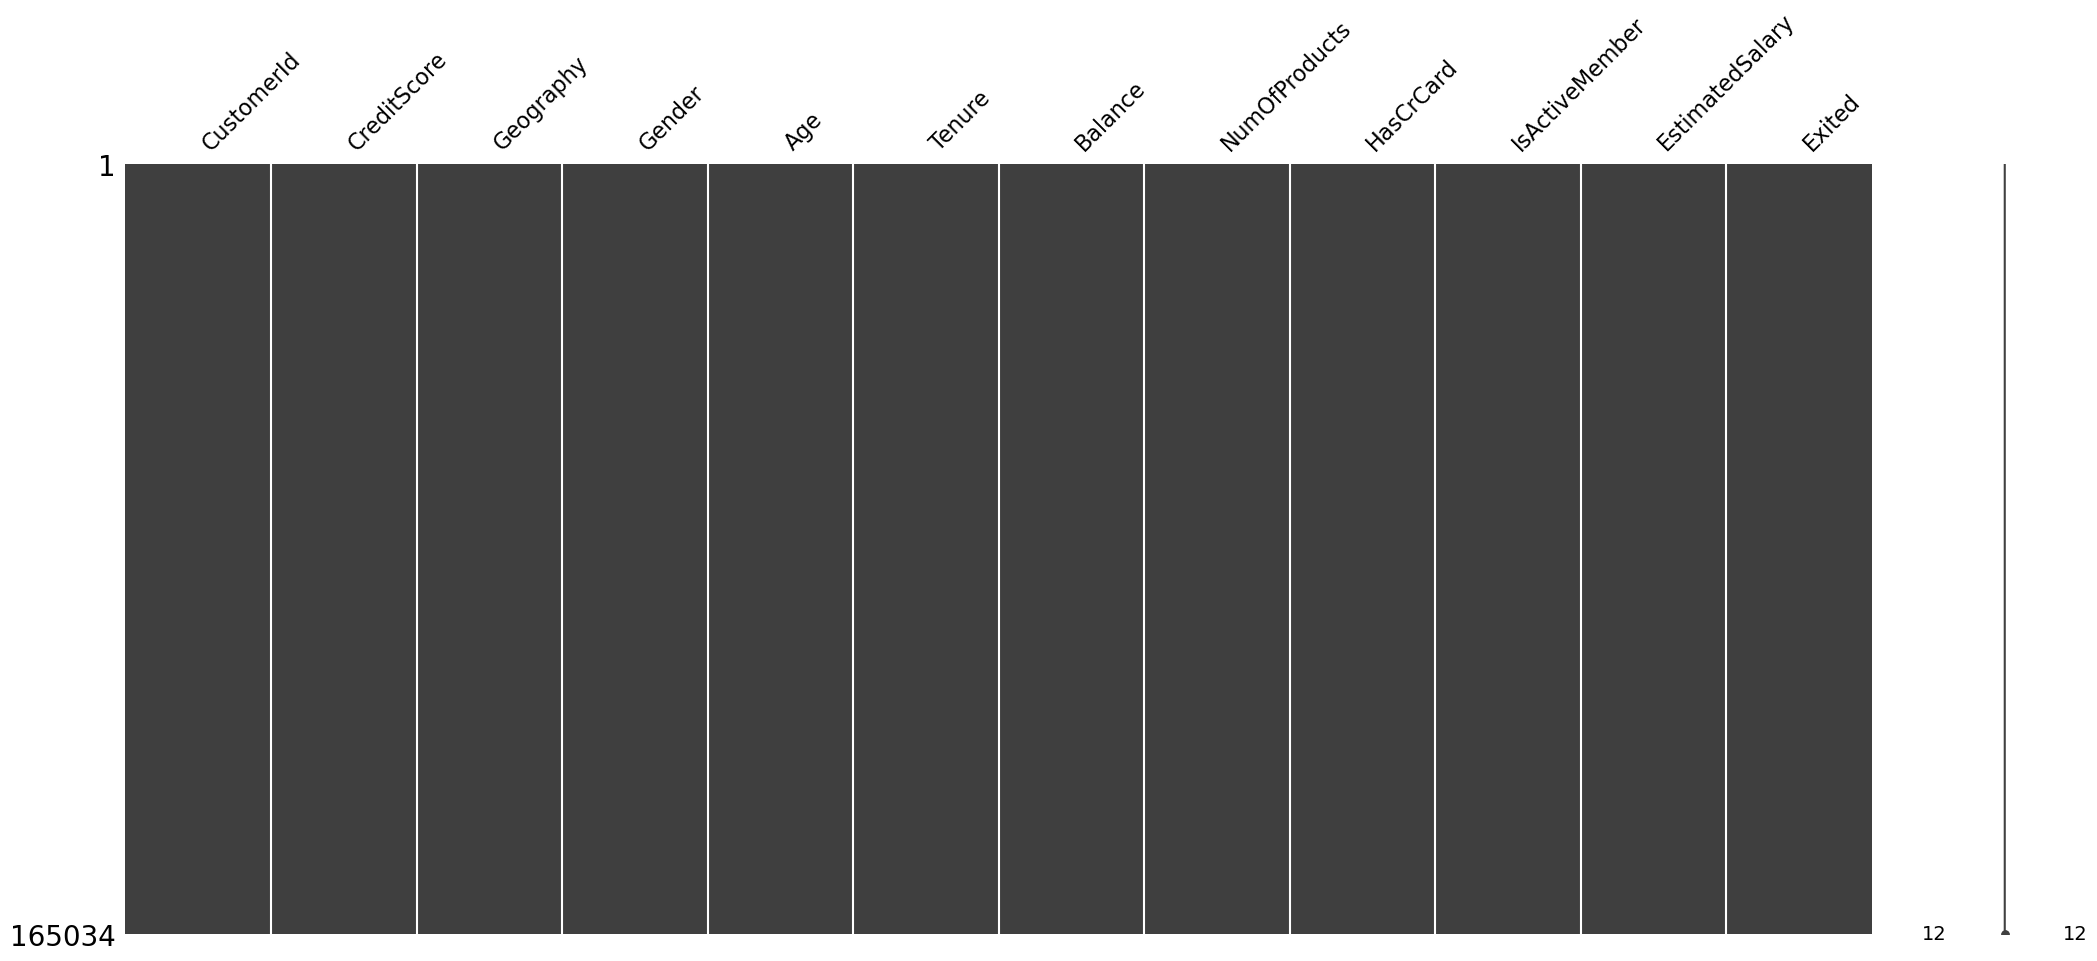

In [18]:
mno.matrix(train)


In [19]:
# train 데이터 중복값 제거
train.duplicated().sum()

30

In [20]:
train.drop_duplicates(inplace=True)

In [21]:
train.duplicated().sum()

0

In [22]:
# train / test 데이터 크기 조회
train.shape

(165004, 12)

In [23]:
# train / test 데이터 크기 및 비율 조회
print(f'Train data : {train.shape}')
print(f'Test data : {test.shape}')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data Percentage : {train_data_percentage * 100}%')
print(f'Test data Percentage : {(1- train_data_percentage) * 100}%')

Train data : (165004, 12)
Test data : (110023, 13)
Train data Percentage : 60.0%
Test data Percentage : 40.0%


In [24]:
# Train 데이터 형식 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165004 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165004 non-null  int64  
 1   CreditScore      165004 non-null  int64  
 2   Geography        165004 non-null  object 
 3   Gender           165004 non-null  object 
 4   Age              165004 non-null  float64
 5   Tenure           165004 non-null  int64  
 6   Balance          165004 non-null  float64
 7   NumOfProducts    165004 non-null  int64  
 8   HasCrCard        165004 non-null  float64
 9   IsActiveMember   165004 non-null  float64
 10  EstimatedSalary  165004 non-null  float64
 11  Exited           165004 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 16.4+ MB


In [25]:
# 문자열 데이터인 Geography와 Gender 상세 개수 확인
train.Geography.value_counts()

Geography
France     94193
Spain      36209
Germany    34602
Name: count, dtype: int64

In [26]:
train.Gender.value_counts()

Gender
Male      93134
Female    71870
Name: count, dtype: int64

---

# Encoding

In [27]:
# one-hot encoding
train_ohe = pd.get_dummies(train[['Geography', 'Gender']])
train_ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,True,False,False,False,True
1,True,False,False,False,True
2,True,False,False,False,True
3,True,False,False,False,True
4,False,False,True,False,True
...,...,...,...,...,...
165029,False,False,True,True,False
165030,True,False,False,False,True
165031,True,False,False,False,True
165032,False,False,True,True,False


In [28]:
pre_ohe = train.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, train_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False,False,True,0
1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False,False,True,0
2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False,False,True,0
3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False,False,True,0
4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True,False,True,0


---

# Modeling
- XGBoost
- CatBoost (추후 추가 예정)

In [29]:
# X, y 데이터 설정
X = data.drop(['Exited', 'CustomerId'], axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.shape, y_train.shape

((132003, 13), (132003,))

In [30]:
# 나눈 데이터의 불균형 정도 확인

print(np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100, '%')

21.12906524851708 %


---

# 함수 정의

In [31]:
# 성능 지표 함수
def print_clf_eval(y_test, pred, pred_proba):

    start_time = time.time()

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)

    confusion = confusion_matrix(y_test, pred)

    print('==> Confusion matrix')
    print(confusion)
    print('====================')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre)) 
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))
    print('Fit time : ', time.time() - start_time)
    print()

    return acc, pre, re, f1, auc

In [32]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    return print_clf_eval(y_test, pred, pred_proba)

In [33]:
# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision',  'Recall',  'F1',  'Roc_Auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [34]:
# 모델별 roc 커브 그리기
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1] 
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])

    plt.plot([0, 1],[0, 1], 'k--', label='random guess') 
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

---

# XGBoost

In [35]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 13, max_depth = 5)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_clf_eval(y_test, xgb_pred, xgb_proba[:, 1])

==> Confusion matrix
[[21364  4613]
 [ 1495  5529]]
Accuracy : 0.8149, Precision : 0.5452
Recall : 0.7872, F1 : 0.6442, AUC : 0.8865
Fit time :  0.17859482765197754



(0.814914699554559,
 0.5451587458095051,
 0.7871583143507973,
 0.6441803565186998,
 0.8864558640581212)

# CatBoost

- 과적합 문제를 해결하면서 학습 속도를 개선하는 장점을 앞세워 개발되었습니다.
- 또한 하이퍼 파라미터에 따라 성능이 달라지는 민감한 문제를 해결하는 것에도 초점을 맞추었습니다.
- (기본 파라미터가 기본적으로 최적화가 잘 되어있어서 파라미터 튜닝에 크게 신경쓰지 않아도 됨)
- 비시계열 데이터라도 CatBoost가 임의로 시계열을 형성해 Boosting을 진행합니다.
- 따라서 Ordered Boosting이라고도 불립니다.
- 결측치가 많은 데이터셋에는 부적합한 모델입니다.

In [36]:
# scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
cat = CatBoostClassifier(random_state=13, max_depth=5, scale_pos_weight=scale_pos_weight)
cat.fit(X_train, y_train)
cat_proba = cat.predict_proba(X_test)
cat_pred = cat.predict(X_test)

print_clf_eval(y_test, cat_pred, cat_proba[:, 1])

Learning rate set to 0.082875
0:	learn: 0.6476913	total: 189ms	remaining: 3m 9s
1:	learn: 0.6099787	total: 217ms	remaining: 1m 48s
2:	learn: 0.5814351	total: 257ms	remaining: 1m 25s
3:	learn: 0.5571673	total: 294ms	remaining: 1m 13s
4:	learn: 0.5373968	total: 330ms	remaining: 1m 5s
5:	learn: 0.5216108	total: 358ms	remaining: 59.3s
6:	learn: 0.5090877	total: 382ms	remaining: 54.2s
7:	learn: 0.4971645	total: 410ms	remaining: 50.8s
8:	learn: 0.4872223	total: 450ms	remaining: 49.6s
9:	learn: 0.4787964	total: 487ms	remaining: 48.3s
10:	learn: 0.4718440	total: 519ms	remaining: 46.6s
11:	learn: 0.4660049	total: 545ms	remaining: 44.9s
12:	learn: 0.4609500	total: 574ms	remaining: 43.6s
13:	learn: 0.4566455	total: 598ms	remaining: 42.1s
14:	learn: 0.4526246	total: 627ms	remaining: 41.2s
15:	learn: 0.4494341	total: 656ms	remaining: 40.3s
16:	learn: 0.4465255	total: 691ms	remaining: 40s
17:	learn: 0.4437809	total: 726ms	remaining: 39.6s
18:	learn: 0.4416199	total: 772ms	remaining: 39.9s
19:	learn:

(0.8156116481318748,
 0.5462516008275047,
 0.7894362186788155,
 0.6457059679767103,
 0.8877732008725434)

---

# 성능 평가표

In [37]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_clf = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
cat_clf = CatBoostClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)

models = [xgb_clf, cat_clf]
model_names = ['XGB', 'CatBoost']
 
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result
     

==> Confusion matrix
[[21204  4773]
 [ 1426  5598]]
Accuracy : 0.8122, Precision : 0.5398
Recall : 0.7970, F1 : 0.6436, AUC : 0.8883
Fit time :  0.11797666549682617

Learning rate set to 0.082875
0:	learn: 0.6566674	total: 25.1ms	remaining: 25.1s
1:	learn: 0.6270603	total: 48.6ms	remaining: 24.2s
2:	learn: 0.6041189	total: 77.7ms	remaining: 25.8s
3:	learn: 0.5836472	total: 101ms	remaining: 25.2s
4:	learn: 0.5667345	total: 124ms	remaining: 24.7s
5:	learn: 0.5536183	total: 145ms	remaining: 24s
6:	learn: 0.5432769	total: 165ms	remaining: 23.4s
7:	learn: 0.5313633	total: 191ms	remaining: 23.7s
8:	learn: 0.5221827	total: 212ms	remaining: 23.3s
9:	learn: 0.5137028	total: 233ms	remaining: 23.1s
10:	learn: 0.5077319	total: 255ms	remaining: 22.9s
11:	learn: 0.5013328	total: 275ms	remaining: 22.6s
12:	learn: 0.4953573	total: 295ms	remaining: 22.4s
13:	learn: 0.4908493	total: 315ms	remaining: 22.2s
14:	learn: 0.4859904	total: 337ms	remaining: 22.1s
15:	learn: 0.4823938	total: 357ms	remaining: 22s

,Accuracy,Precision,Recall,F1,Roc_Auc
XGB,0.812157,0.539774,0.796982,0.643633,0.888264
CatBoost,0.812763,0.540865,0.796128,0.644128,0.889069


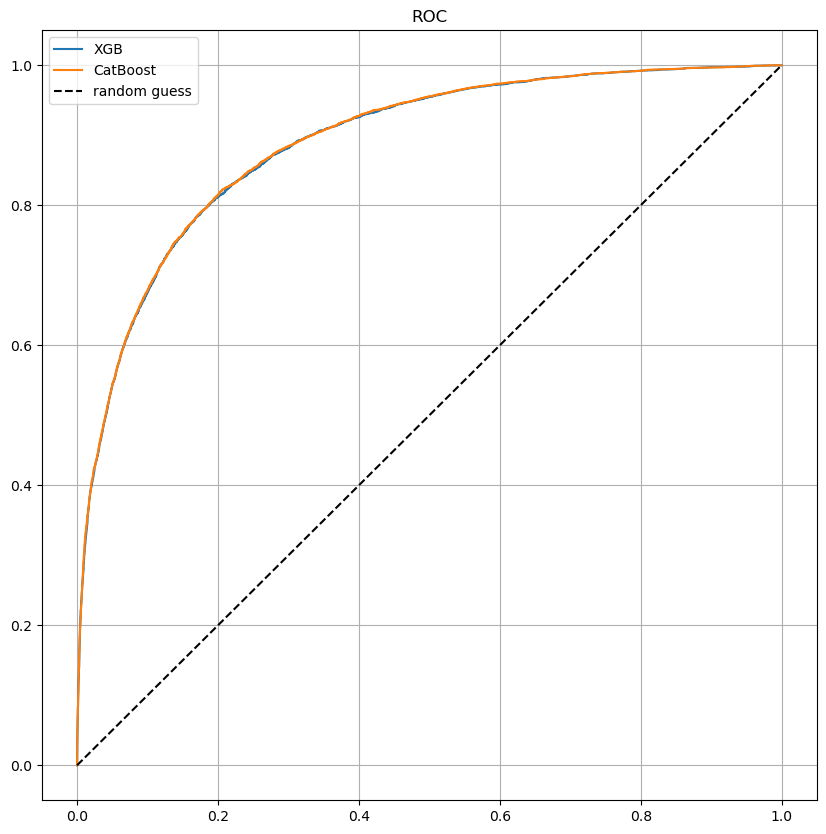

In [38]:
# class weight
draw_roc_curve(models, model_names, X_test, y_test)

---

# 최적의 파라미터값 구하기(GridSearchCV)

하이퍼 파라미터 튜닝 진행
- xgb
- cat


#### XGB

In [39]:
params = {
    'n_estimators': [800, 1000, 3000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.8]
}

xgb_grid = GridSearchCV(xgb_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [40]:
# best score 체크
print(f'grid.best_score: {xgb_grid.best_score_}')

# best params 체크
print(f'grid.best_params: {xgb_grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, xgb_grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8895357217962986
grid.best_params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}


accuracy score of test data: 0.8143692615375292


#### CatBoost

In [41]:
params = {
    'n_estimators': [800, 1000, 3000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [1, 3, 5]
}

cat_grid = GridSearchCV(cat_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
cat_grid.fit(X_train, y_train)
cat_best = cat_grid.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


0:	learn: 0.6873644	total: 45.2ms	remaining: 2m 15s
1:	learn: 0.6815465	total: 89.6ms	remaining: 2m 14s
2:	learn: 0.6762713	total: 122ms	remaining: 2m 2s
3:	learn: 0.6708277	total: 152ms	remaining: 1m 53s
4:	learn: 0.6659404	total: 189ms	remaining: 1m 53s
5:	learn: 0.6610246	total: 217ms	remaining: 1m 48s
6:	learn: 0.6559969	total: 246ms	remaining: 1m 45s
7:	learn: 0.6509736	total: 299ms	remaining: 1m 51s
8:	learn: 0.6461811	total: 361ms	remaining: 1m 59s
9:	learn: 0.6416203	total: 393ms	remaining: 1m 57s
10:	learn: 0.6370586	total: 431ms	remaining: 1m 57s
11:	learn: 0.6327078	total: 460ms	remaining: 1m 54s
12:	learn: 0.6283644	total: 489ms	remaining: 1m 52s
13:	learn: 0.6240642	total: 526ms	remaining: 1m 52s
14:	learn: 0.6199083	total: 567ms	remaining: 1m 52s
15:	learn: 0.6159711	total: 597ms	remaining: 1m 51s
16:	learn: 0.6120607	total: 629ms	remaining: 1m 50s
17:	learn: 0.6081060	total: 657ms	remaining: 1m 48s
18:	learn: 0.6044650	total: 686ms	remaining: 1m 47s
19:	learn: 0.6007754	

In [42]:
# best score 체크
print(f'grid.best_score: {cat_grid.best_score_}')

# best params 체크
print(f'grid.best_params: {cat_grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, cat_grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8895029368592374
grid.best_params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 3000}
accuracy score of test data: 0.8131874791672979


#### 비교

In [43]:
# 그리드서치 후 모델 성능 비교
models = [xgb_best, cat_best]
model_names = ['XGB', 'CatBoost']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results

==> Confusion matrix
[[21286  4691]
 [ 1435  5589]]
Accuracy : 0.8144, Precision : 0.5437
Recall : 0.7957, F1 : 0.6460, AUC : 0.8886
Fit time :  0.13286757469177246

0:	learn: 0.6873644	total: 26.9ms	remaining: 1m 20s
1:	learn: 0.6815465	total: 54.4ms	remaining: 1m 21s
2:	learn: 0.6762713	total: 83.6ms	remaining: 1m 23s
3:	learn: 0.6708277	total: 111ms	remaining: 1m 23s
4:	learn: 0.6659404	total: 136ms	remaining: 1m 21s
5:	learn: 0.6610246	total: 166ms	remaining: 1m 22s
6:	learn: 0.6559969	total: 200ms	remaining: 1m 25s
7:	learn: 0.6509736	total: 228ms	remaining: 1m 25s
8:	learn: 0.6461811	total: 259ms	remaining: 1m 26s
9:	learn: 0.6416203	total: 287ms	remaining: 1m 25s
10:	learn: 0.6370586	total: 315ms	remaining: 1m 25s
11:	learn: 0.6327078	total: 346ms	remaining: 1m 26s
12:	learn: 0.6283644	total: 372ms	remaining: 1m 25s
13:	learn: 0.6240642	total: 400ms	remaining: 1m 25s
14:	learn: 0.6199083	total: 441ms	remaining: 1m 27s
15:	learn: 0.6159711	total: 477ms	remaining: 1m 28s
16:	learn

,Accuracy,Precision,Recall,F1,Roc_Auc
XGB,0.814369,0.543677,0.795700,0.645978,0.888560
CatBoost,0.813187,0.541566,0.796697,0.644812,0.888853


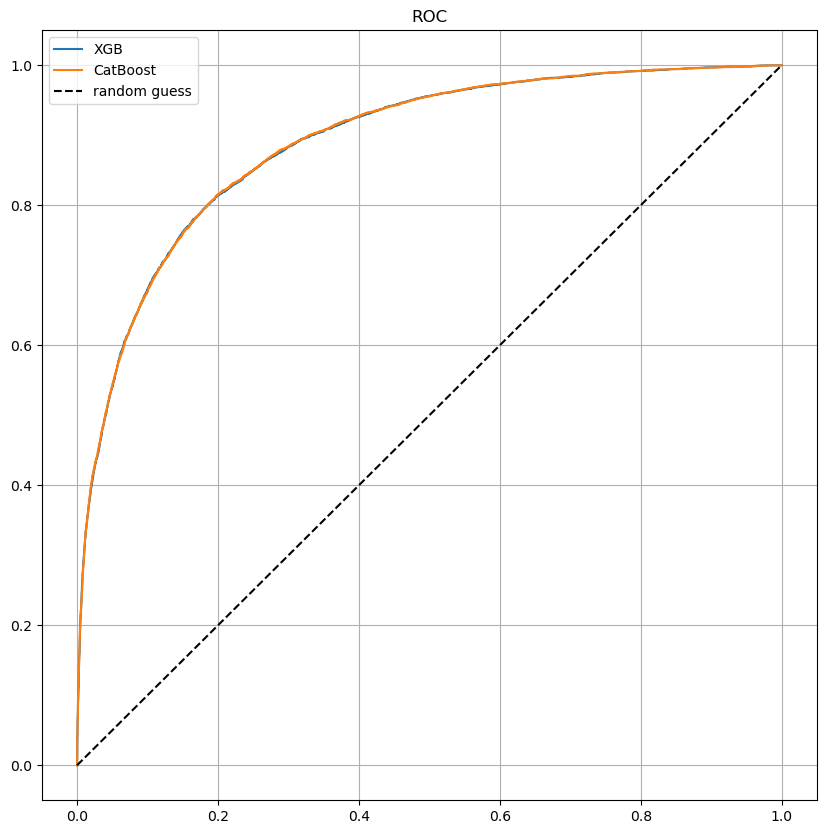

In [44]:
# roc 곡선 그리기
draw_roc_curve(models, model_names, X_test, y_test)

---

# 중요 특성 파악하기

#### xgb

In [45]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = xgb_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        0.402654
Age                  0.226216
IsActiveMember       0.136057
Geography_Germany    0.071775
Gender_Female        0.060565
Balance              0.044408
HasCrCard            0.017522
CreditScore          0.009273
EstimatedSalary      0.008589
Tenure               0.008119
Geography_France     0.007875
Geography_Spain      0.006947
Gender_Male          0.000000
dtype: float32

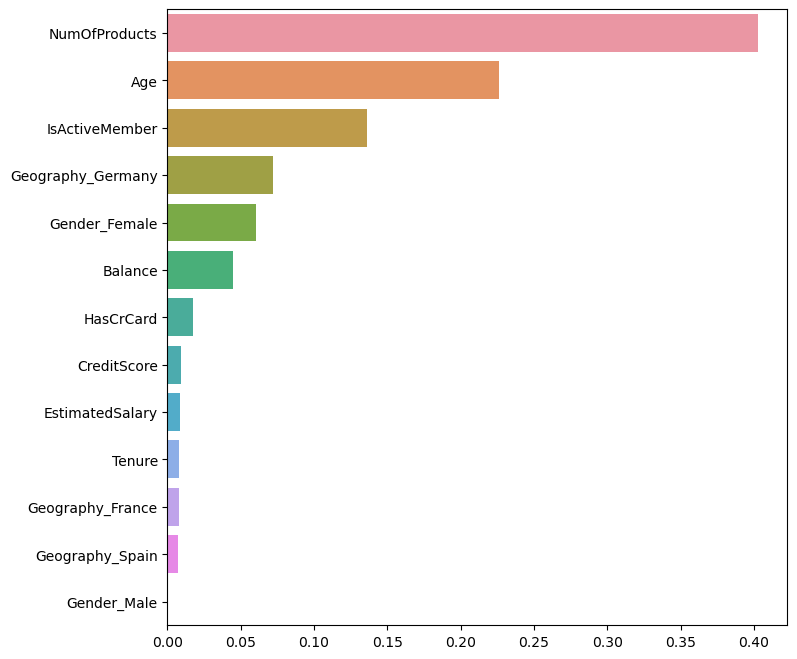

In [46]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

#### cat

In [47]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = cat_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        44.244343
Age                  24.884307
IsActiveMember        8.807255
Balance               7.525509
Geography_Germany     5.308266
CreditScore           2.237695
EstimatedSalary       2.096471
Gender_Female         1.576714
Gender_Male           1.522666
Tenure                0.941808
HasCrCard             0.584194
Geography_France      0.199083
Geography_Spain       0.071688
dtype: float64

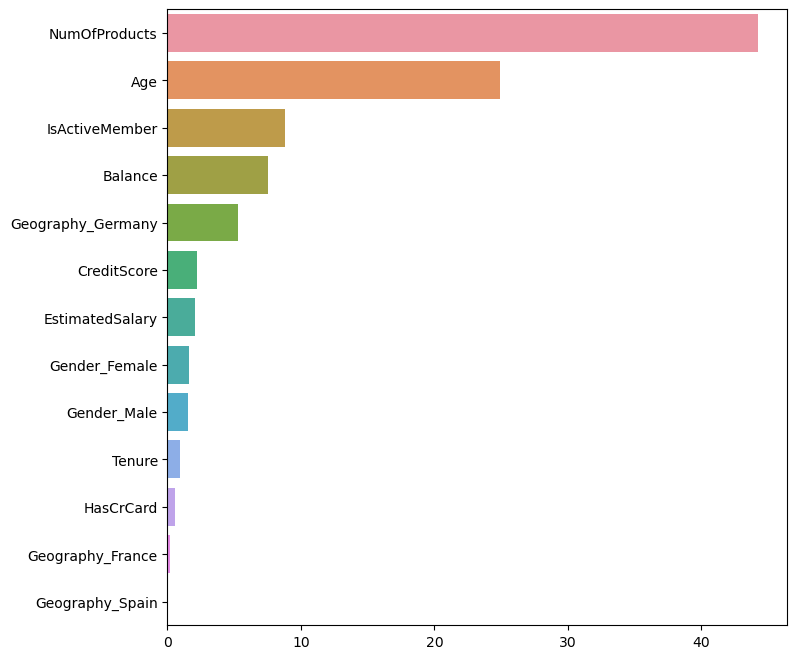

In [48]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

---

# Final 결과도출
- original 데이터셋으로 test 진행

In [49]:
original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [50]:
original = original.drop(['RowNumber', 'Surname'], axis=1)
original.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [51]:
original.duplicated().sum()

2

In [52]:
original.drop_duplicates(inplace = True)
original.dropna(inplace=True)
original.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,15574012,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1


In [53]:
real_ex = original['Exited']
original = original.drop(['CustomerId', 'Exited'], axis=1)
original_encoding = pd.get_dummies(original, columns=['Geography','Gender'])
original_encoding.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,True,False,False,True,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,False,False,True,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,True,False,False,True,False
3,699,39.0,1,0.00,2,0.0,0.0,93826.63,True,False,False,True,False
5,645,44.0,8,113755.78,2,1.0,0.0,149756.71,False,False,True,False,True


1) xgboost 모델 / origin data로 테스트 진행

In [54]:
xgb_pred = xgb_best.predict(original_encoding)
xgb_pred_proba = xgb_best.predict_proba(original_encoding)[:, 1]
print_clf_eval(real_ex, xgb_pred, xgb_pred_proba)

==> Confusion matrix
[[6265 1694]
 [ 449 1588]]
Accuracy : 0.7856, Precision : 0.4839
Recall : 0.7796, F1 : 0.5971, AUC : 0.8692
Fit time :  0.06134772300720215



(0.7856142456982793,
 0.4838513101767215,
 0.7795778105056456,
 0.59710471893213,
 0.869169084094028)

2) catboost 모델 / origin data로 테스트 진행

In [55]:
cat_pred = cat_best.predict(original_encoding)
cat_pred_proba = cat_best.predict_proba(original_encoding)[:, 1]
print_clf_eval(real_ex, cat_pred, cat_pred_proba)

==> Confusion matrix
[[6250 1709]
 [ 439 1598]]
Accuracy : 0.7851, Precision : 0.4832
Recall : 0.7845, F1 : 0.5981, AUC : 0.8697
Fit time :  0.0488734245300293



(0.7851140456182473,
 0.48321741759903236,
 0.7844869906725577,
 0.5980538922155689,
 0.8697222997859119)

### catboost 모델링 original test 결과 해석:
- 전체 9996명 (0: 7959 / 1: 2037)
- 실제 이탈하지 않은 7959명 중에 6250명을 0으로 잘 예측, 1709명은 1로 잘못 예측
- 실제 이탈한 2037명 중에 1598명을 1로 잘 예측, 439명은 0으로 잘못 예측

In [56]:
# original_encoding['Predict_ex'] = cat_pred
# original_encoding.head()

In [57]:
# result = original_encoding
# result['Real_ex'] = real_ex
# result

In [58]:
original['Predict_ex'] = cat_pred
original.head()
result = original
result['Real_ex'] = real_ex
result

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict_ex,Real_ex
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,0,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0,1


---

## 결과 EDA 

- 참고사항:
    - 승환님: xgb로 eda 진행
    - 본 파일은 cat으로 eda 진행

In [60]:
def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    i = 0
    for co in col:
        tie = ['Predict_ex', 'Real_ex']
        fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

        textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
        ax[0].pie(df[co].value_counts().to_list(),
                colors=pie_colors,
                labels=df[co].value_counts().index.to_list(),
                autopct='%1.f%%', 
                explode=([.05]*df[co].nunique()),
                pctdistance=0.5,
                wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
                textprops=textprops)

        sns.countplot(x = co, data=df, palette = "pastel6", order=df[co].value_counts().to_dict().keys())
        for p, count in enumerate(df[co].value_counts()):
            ax[1].text(p-0.11, count+np.sqrt(count)+1000, count, color='black', fontsize=13)
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        plt.yticks([])
        plt.box(False)
        fig.suptitle(x=0.56, t=f'► {tie[i]} {title} Distribution ◄', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()
        i+=1

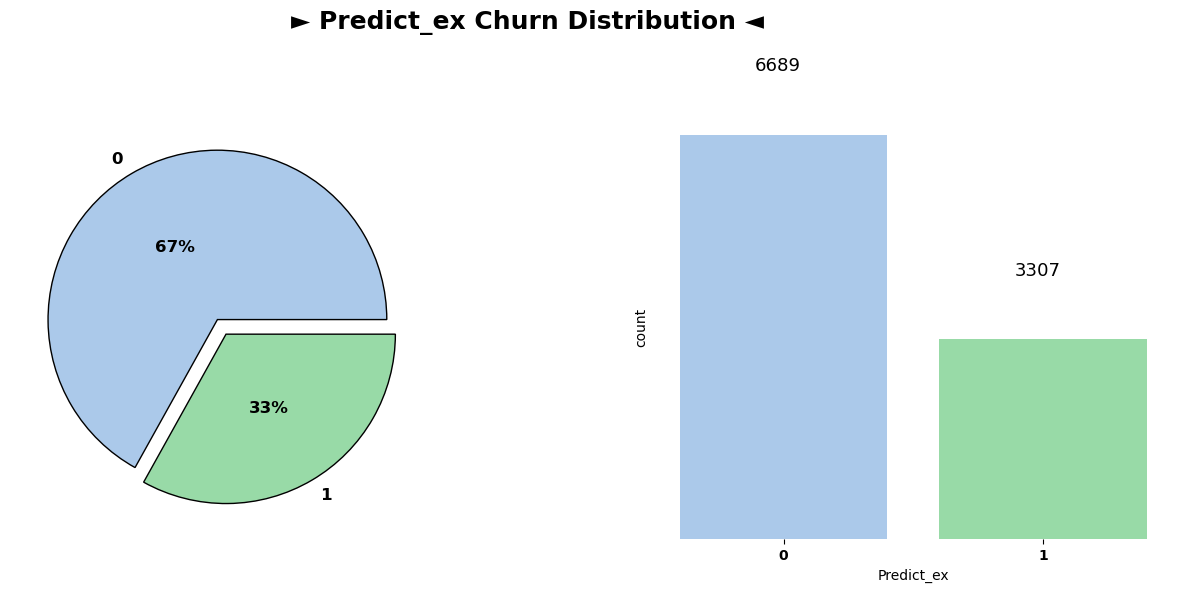

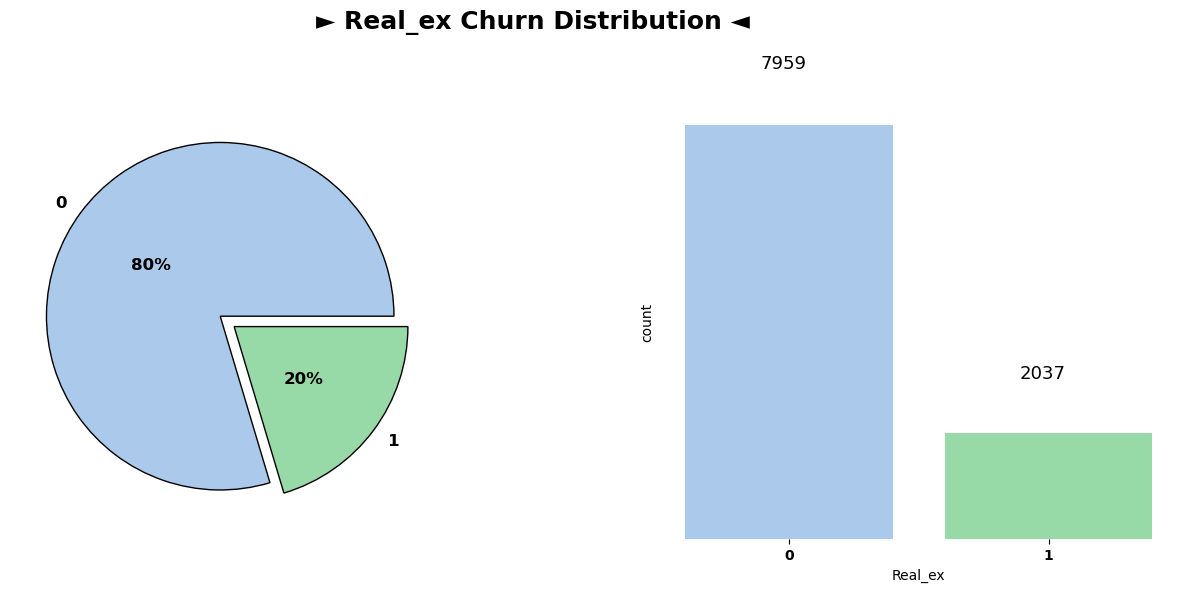

In [61]:
plot_target(result, 
            col=["Predict_ex", "Real_ex"], 
            title="Churn", 
            pie_colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])

In [62]:
result.loc[result['Predict_ex'] != result['Real_ex']]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Predict_ex,Real_ex
18,587,Spain,Male,45.25,6,0.00,1,0.0,0.0,158684.81,1,0
24,846,France,Female,38.00,5,0.00,1,1.0,1.0,187616.16,1,0
28,574,Germany,Female,43.00,3,141349.43,1,1.0,1.0,100187.43,1,0
32,553,Germany,Male,41.00,9,110112.54,2,0.0,0.0,81898.81,1,0
40,472,Spain,Male,40.00,4,0.00,1,1.0,0.0,70154.22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9979,677,France,Female,58.00,1,90022.85,1,0.0,1.0,2988.28,1,0
9983,613,France,Male,40.00,4,0.00,1,0.0,0.0,151325.24,1,0
9990,714,Germany,Male,33.00,3,35016.60,1,1.0,0.0,53667.08,1,0
9997,709,France,Female,36.00,7,0.00,1,0.0,1.0,42085.58,0,1


In [63]:
len(result.loc[result['Predict_ex'] != result['Real_ex']])

2148

In [64]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

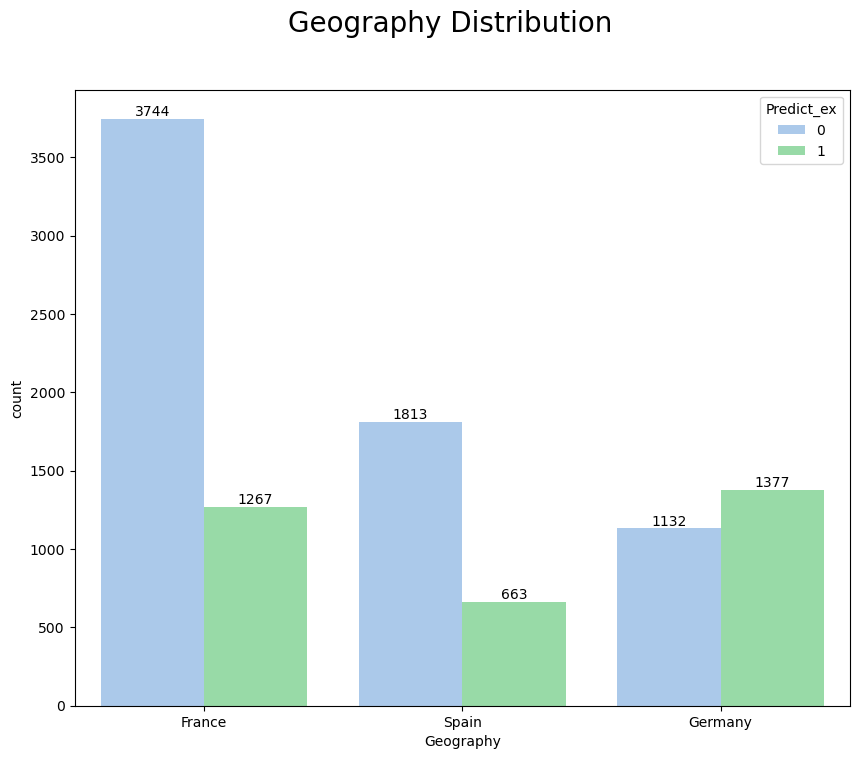

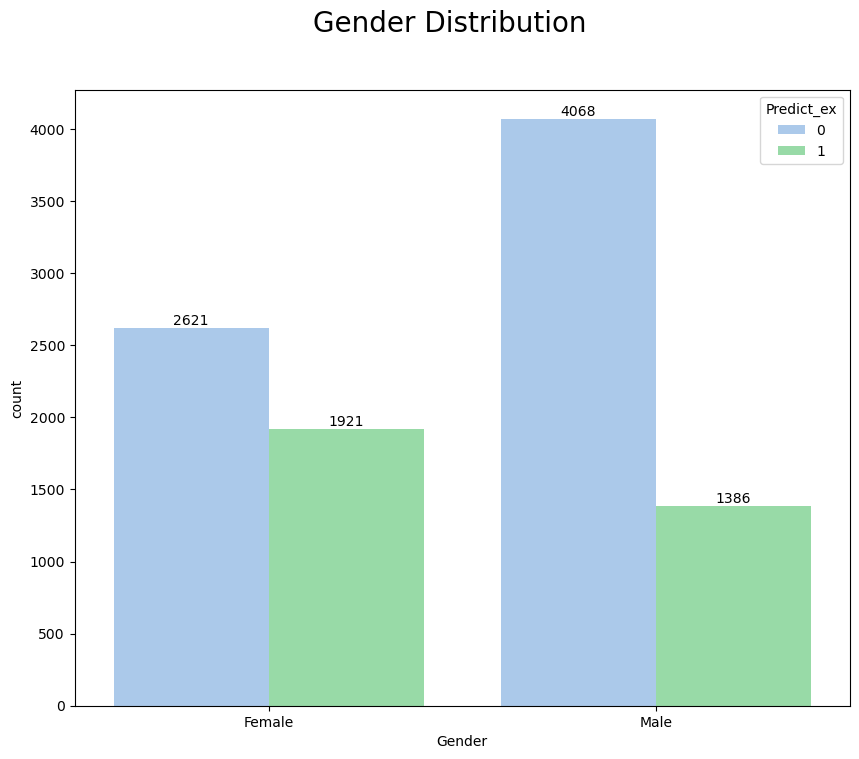

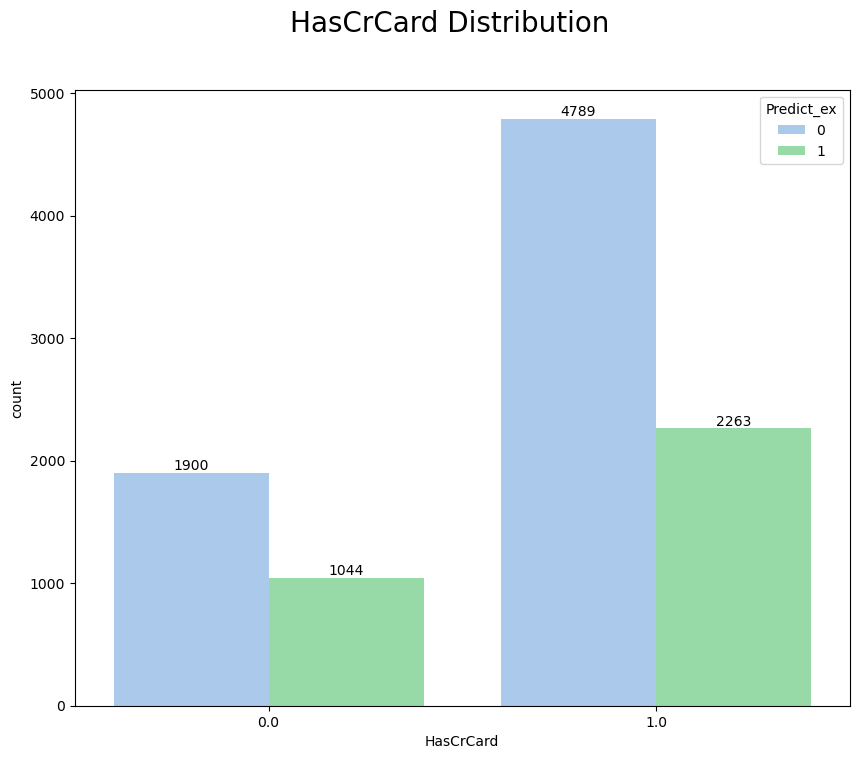

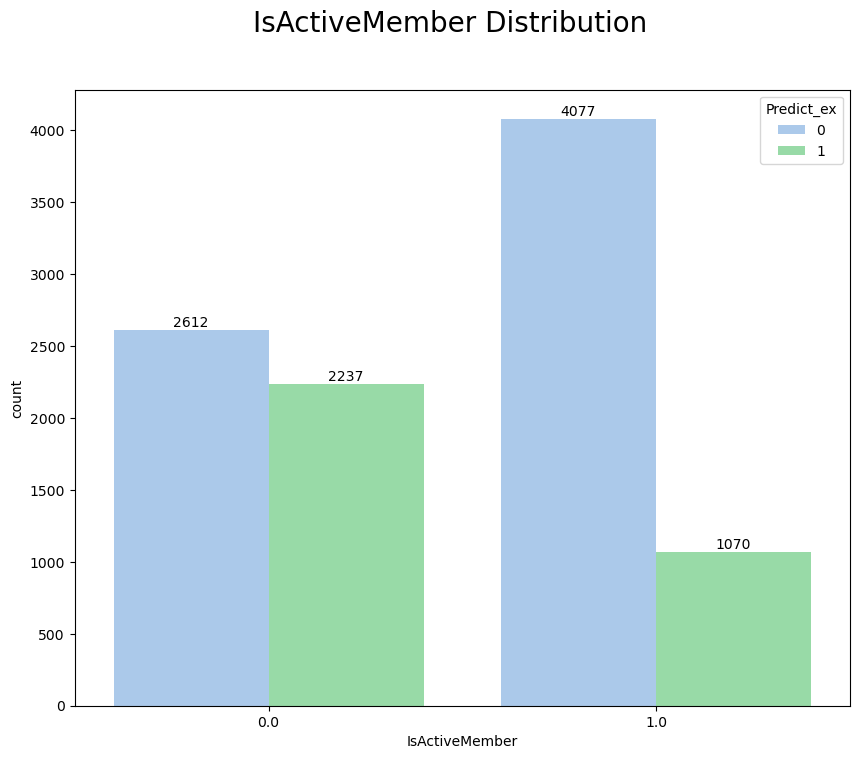

In [65]:
for column in cat_cols:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.countplot(hue="Predict_ex", x=column, data=result, palette="pastel6",)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.suptitle(f'{column} Distribution',fontsize=20)
    plt.show()

In [66]:
def create_mosaic_plot(df, col1, col2):
    col1_values = df[col1].unique()
    col2_values = df[col2].unique()

    color_palette = plt.cm.get_cmap('Pastel1', len(col1_values))
    colors = {str(val): color_palette(i) for i, val in enumerate(col1_values)}
    
    alphas = np.linspace(0.3, 0.7, len(col2_values))
    alpha_dict = {str(val): alpha for val, alpha in zip(col2_values, alphas)}
    
    def props(key):
        color = colors.get(str(key[0]), (0, 0, 0))
        alpha = alpha_dict.get(str(key[1]), 1)
        return {'color': color[:3] + (alpha,)}

    def labels(key):
        lab1 = {str(val): str(val) for val in col1_values}
        lab2 = {str(val): str(val) for val in col2_values} if col2 != 'Exited' else {'1': 'exited', '0': 'not exited'}

        label = f'{lab1.get(key[0], "unknown")} & {lab2.get(key[1], "unknown")}'
        return label

    fig, ax = plt.subplots(figsize=(16, 8))
    mosaic(df, [col1, col2], properties=props, labelizer=labels, ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.grid(False)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24268\4112873965.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Pastel1', len(col1_values))


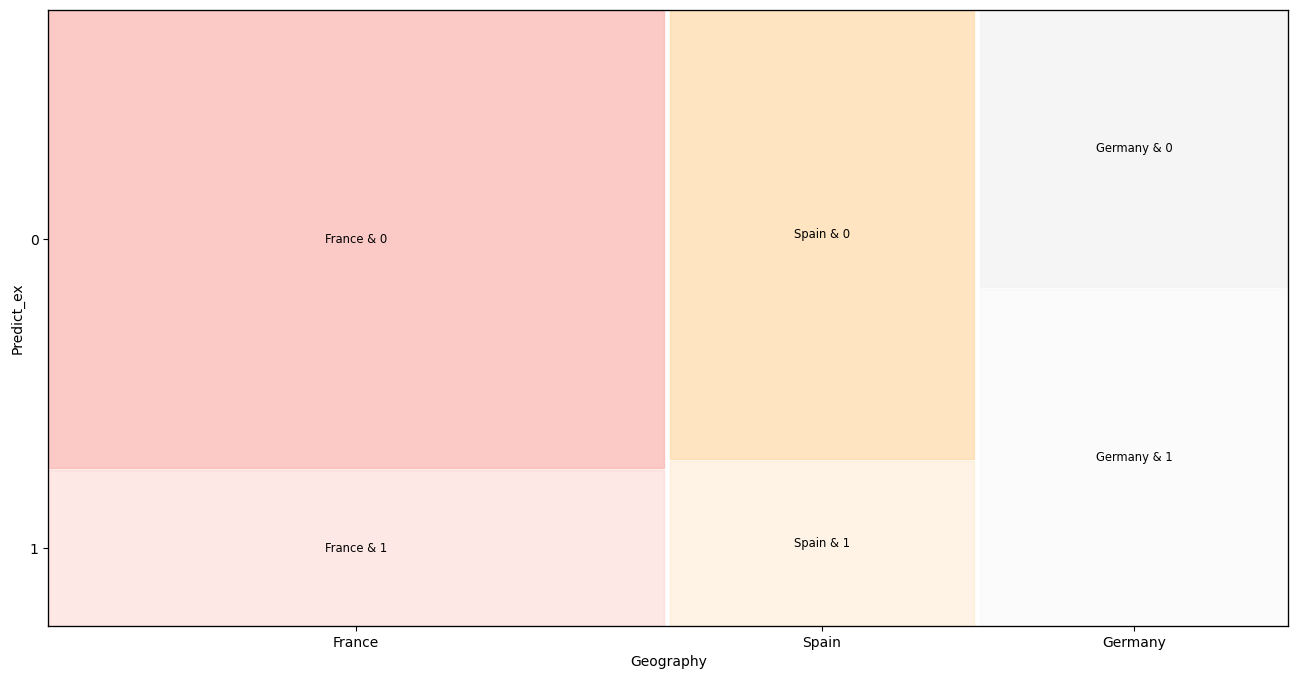

In [67]:
create_mosaic_plot(result, 'Geography', 'Predict_ex')

C:\Users\User\AppData\Local\Temp\ipykernel_24268\4112873965.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Pastel1', len(col1_values))


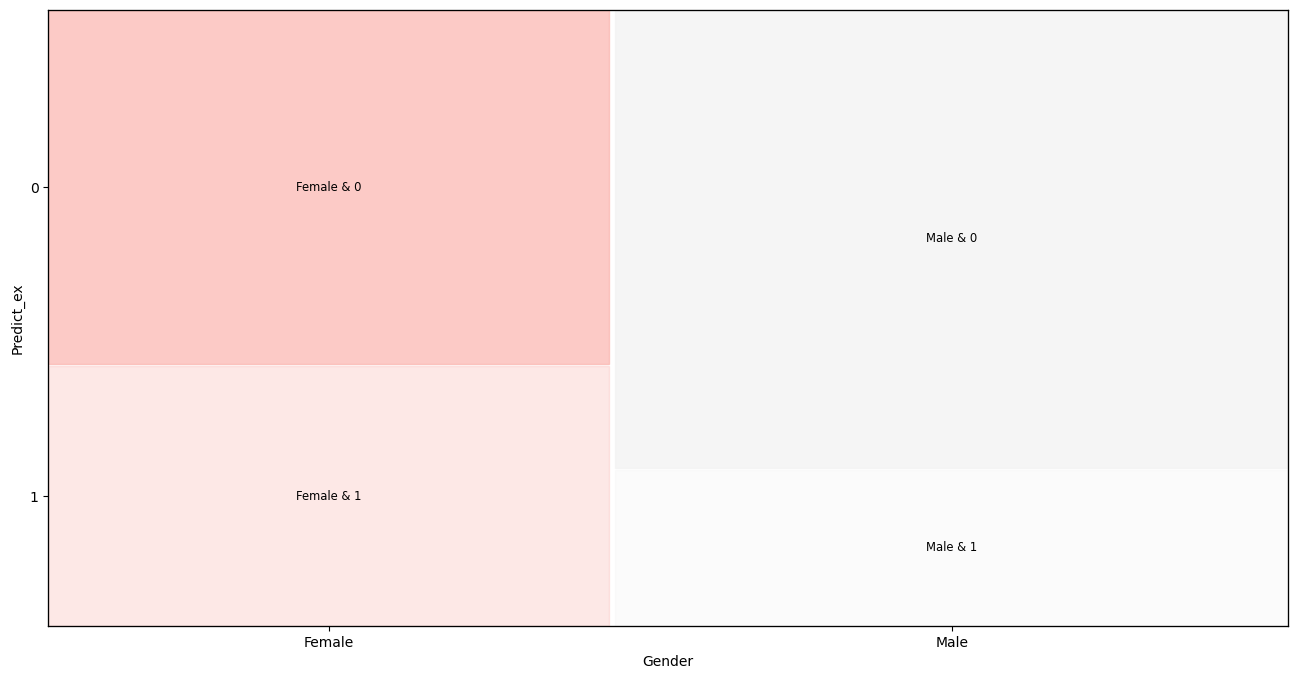

In [68]:
create_mosaic_plot(result, 'Gender', 'Predict_ex')

<Figure size 1400x1000 with 0 Axes>

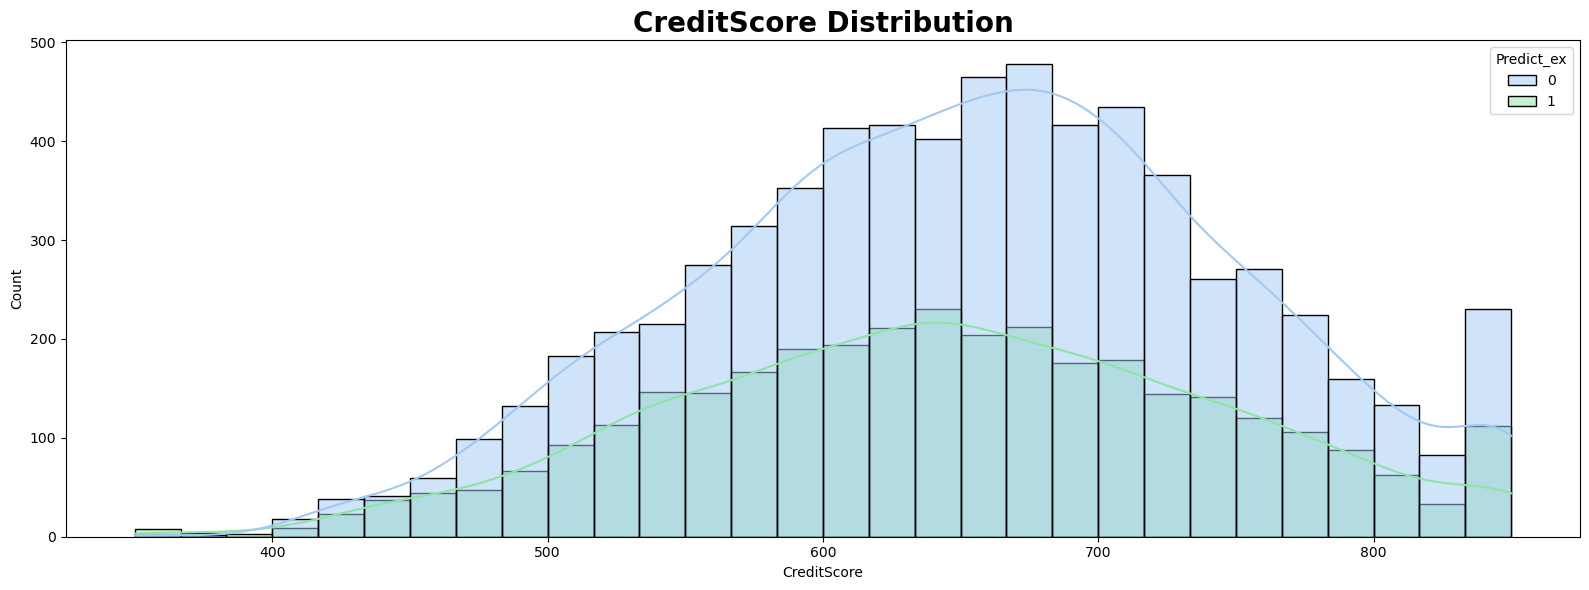

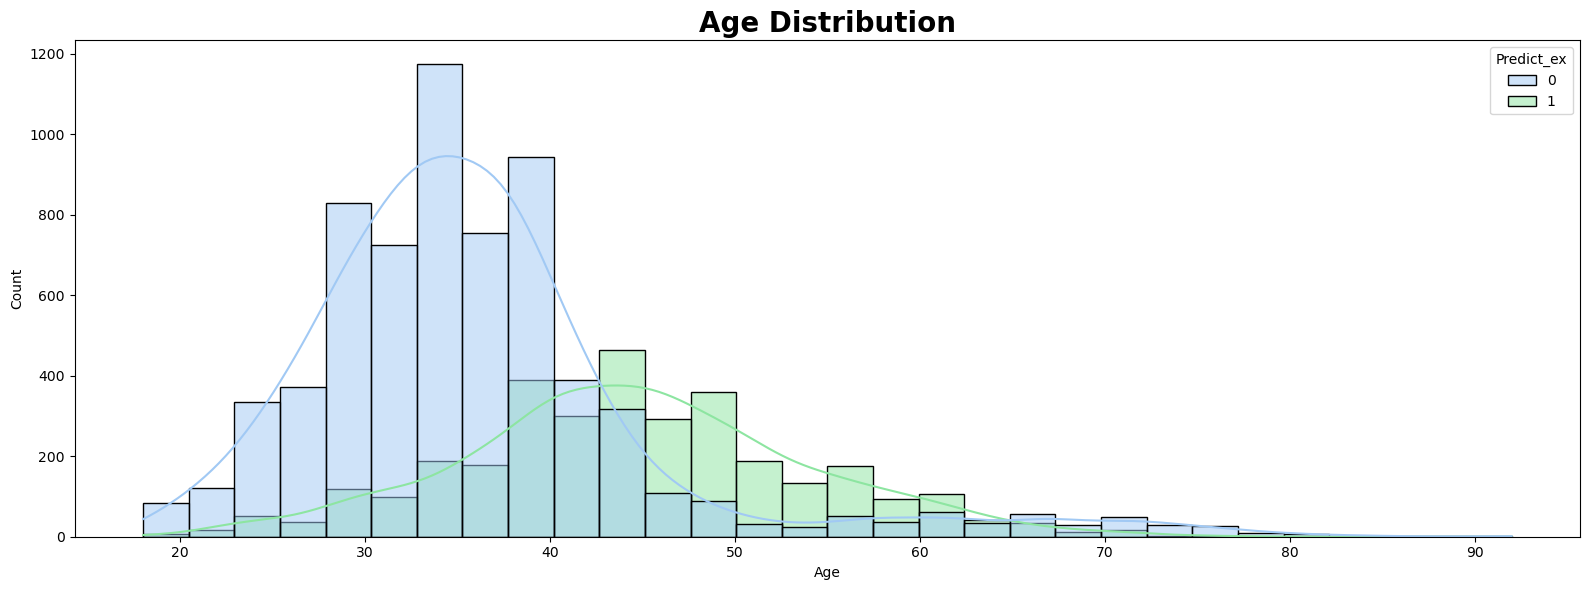

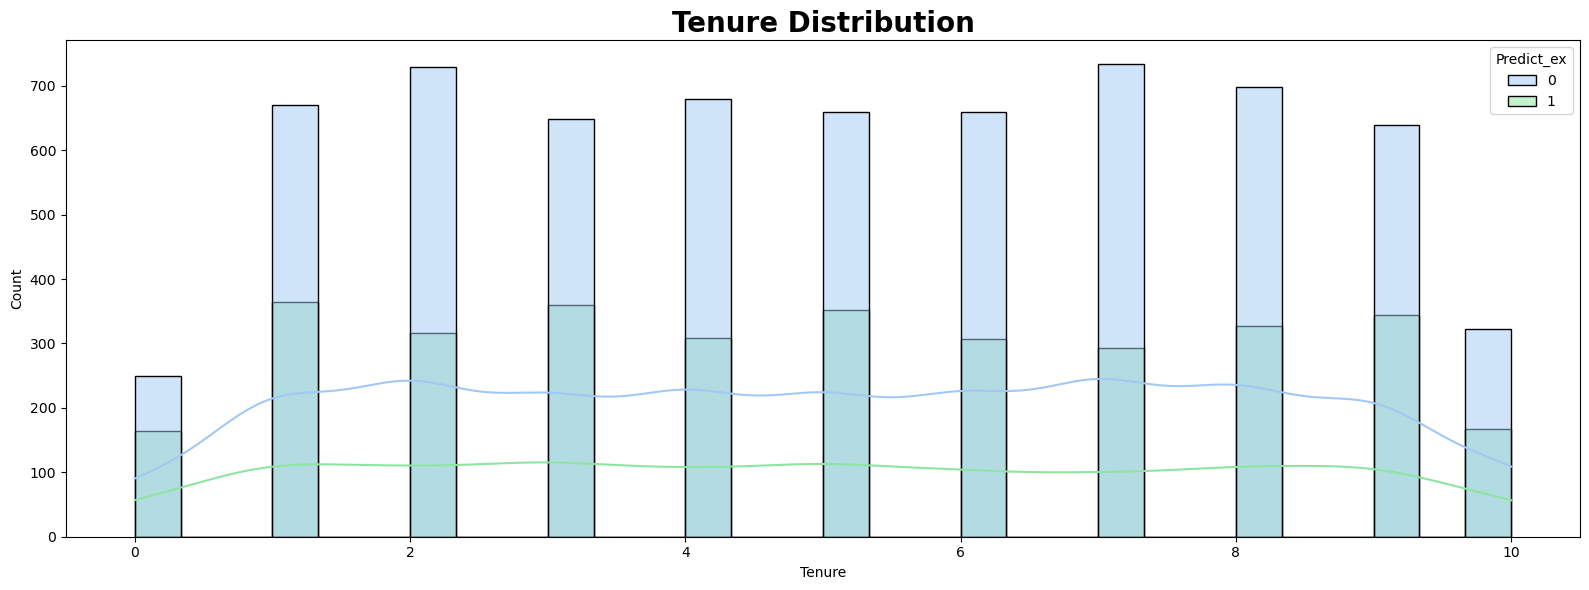

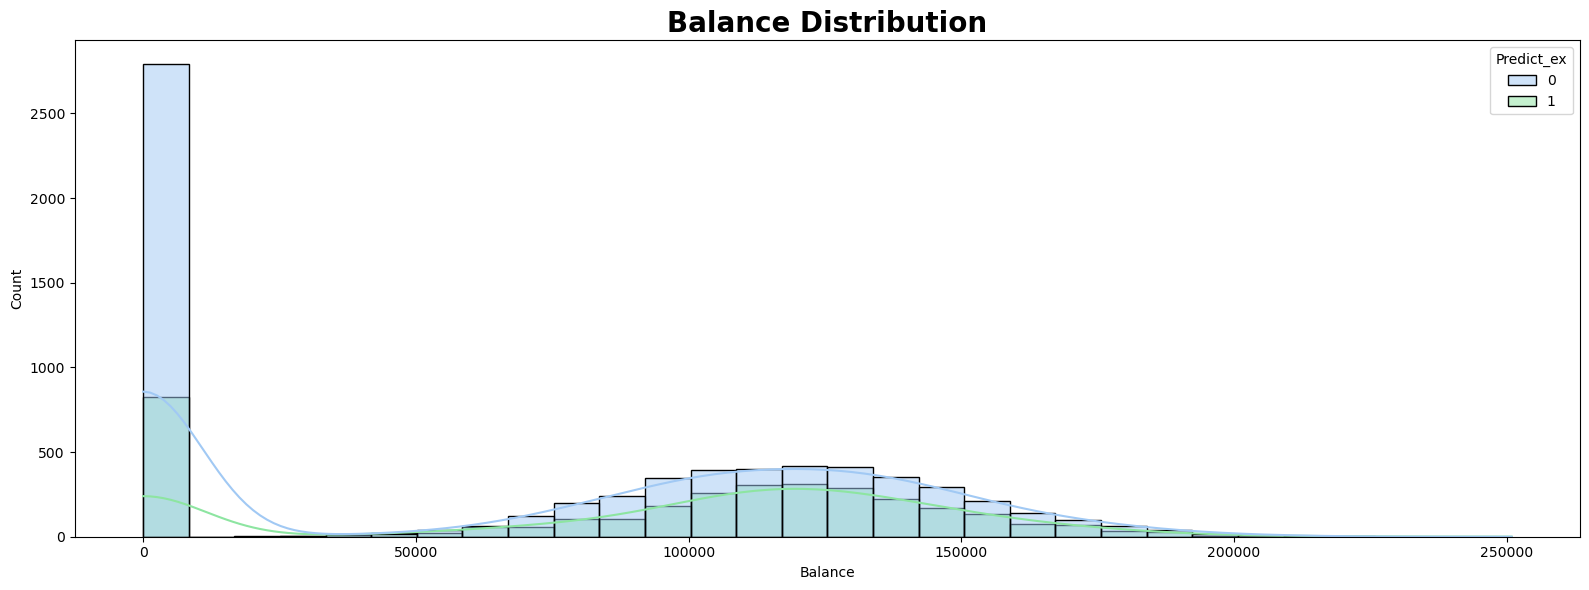

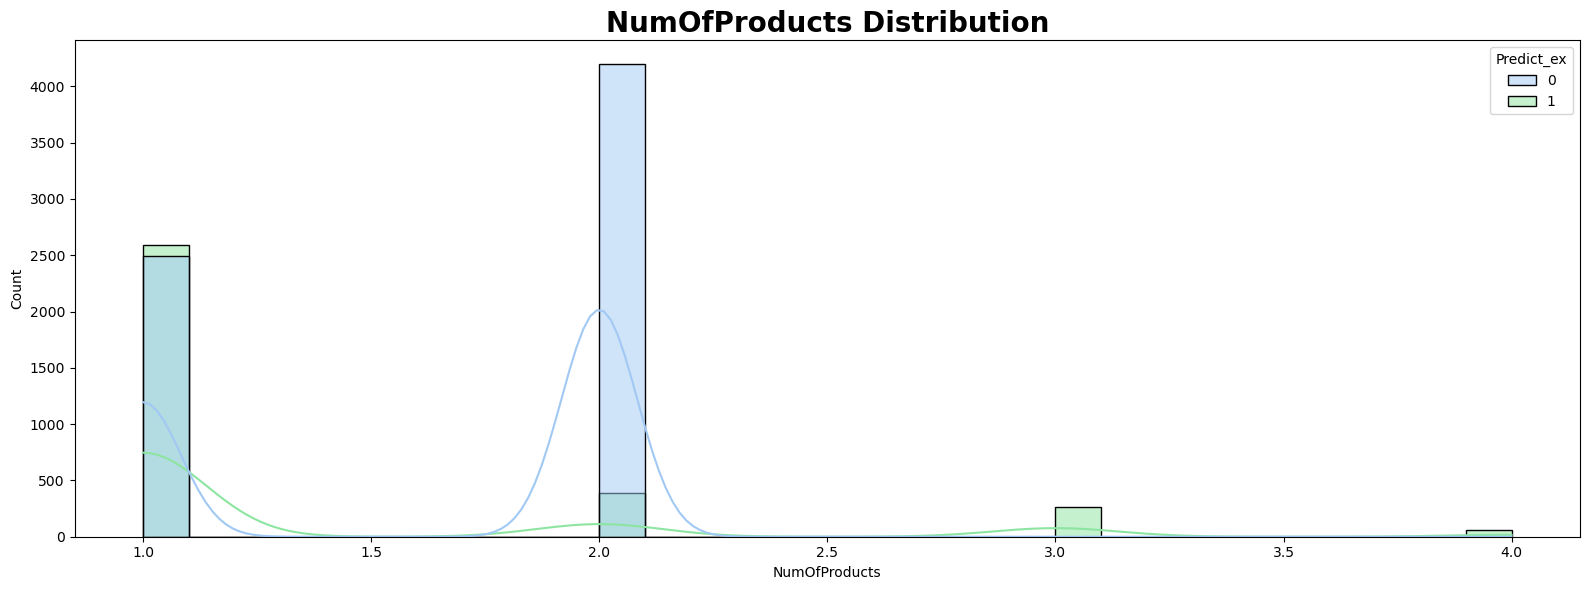

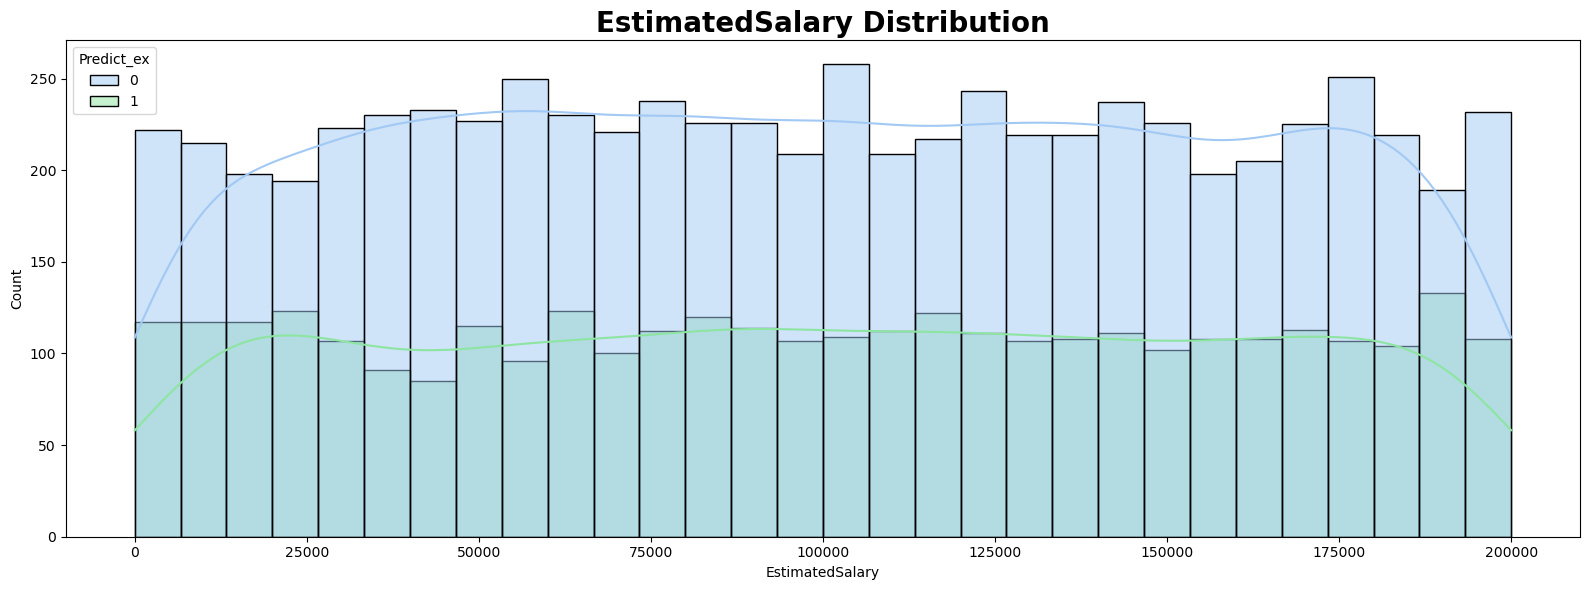

In [69]:
plt.figure(figsize=(14,10))
for idx,column in enumerate(num_cols):
    fig, ax = plt.subplots(figsize=(16, 6))
    fig = sns.histplot(x=column, hue="Predict_ex", data=result,bins=30,kde=True, palette="pastel6")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout();

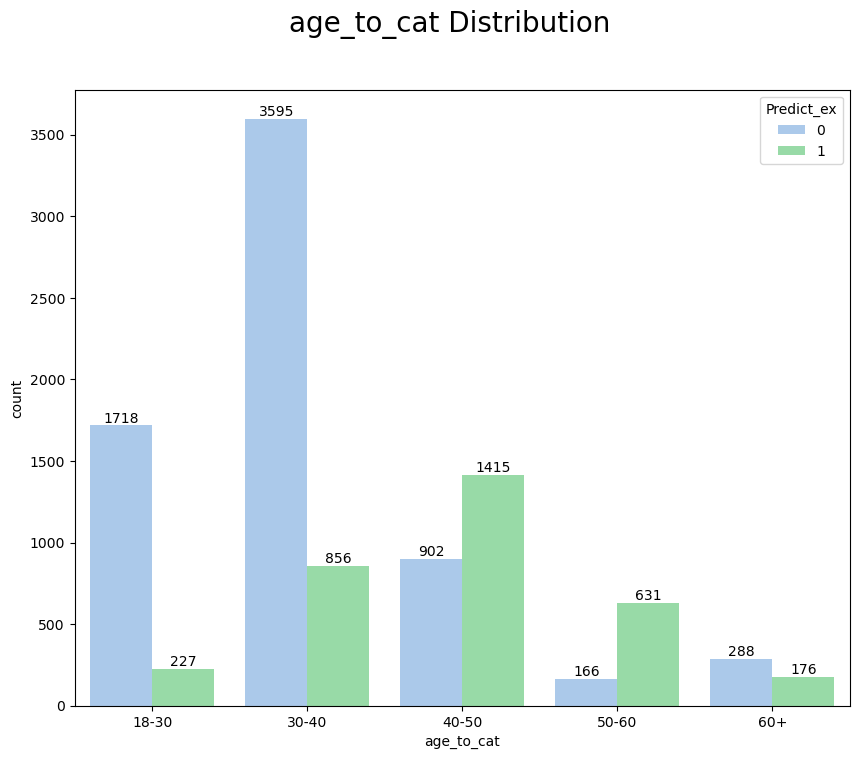

In [72]:
result['age_to_cat'] = pd.cut(result['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(hue="Predict_ex", x='age_to_cat', data=result, palette="pastel6",)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.suptitle('age_to_cat Distribution',fontsize=20)
plt.show()

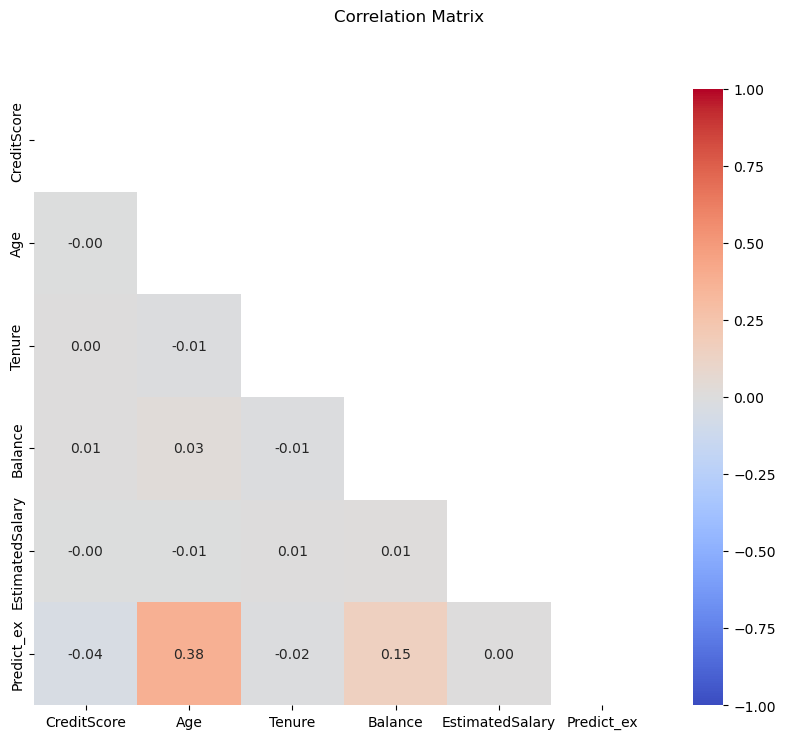

In [73]:
result_digit = result[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Predict_ex']].copy()

corr_matrix = result_digit.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f,ax=plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.suptitle('Correlation Matrix')
plt.show()

In [74]:
result_cat_digit = result[['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Predict_ex']].copy()
geo_plus_gen = result[['Geography','Gender']].copy()
geo_plus_gen

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
5,Spain,Male
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


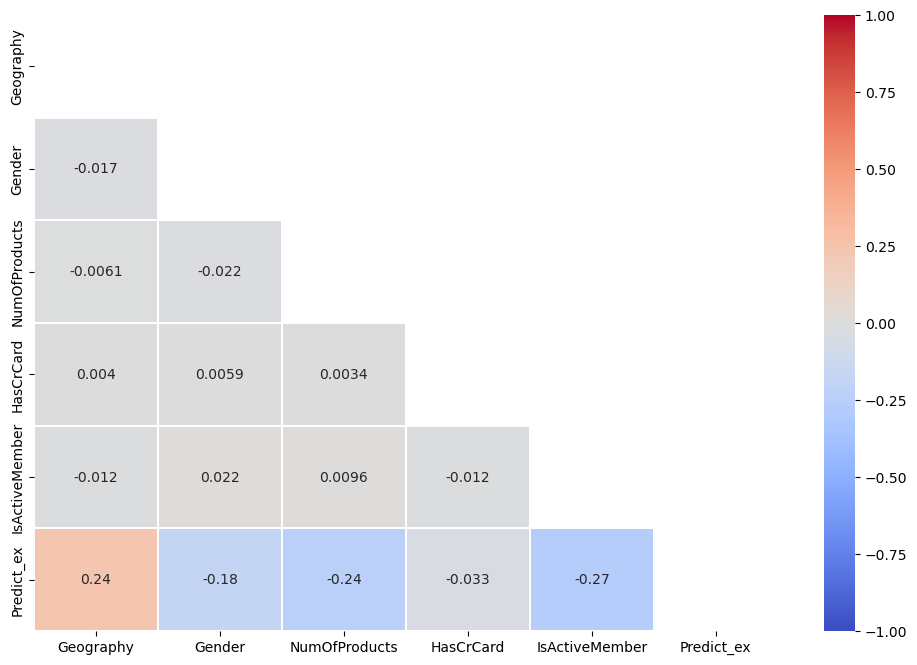

In [75]:
df_cat = geo_plus_gen.apply(lambda x: pd.factorize(x)[0])
df_cat_corr = pd.concat([df_cat, result_cat_digit],axis = 1).corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))
ax = sns.heatmap(df_cat_corr, mask=mask, xticklabels=df_cat_corr.columns, yticklabels=df_cat_corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)